# PCA on UKBB Meshes

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
import seaborn as sns
import torch

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')

import pyvista as pv
pv.set_plot_theme("document")

import coma.utils.decomposition
from coma.utils.visualise import plot_single_mesh, plot_mesh

pd.options.display.max_colwidth = 100

In [3]:
sns.set_context("paper")
sns.set_palette("muted", desat=1)
palette_list = list(sns.color_palette())
sns.color_palette()

[(0.2823529411764707, 0.4705882352941174, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.29019607843137263),
 (0.415686274509804, 0.7999999999999998, 0.3921568627450982),
 (0.8392156862745099, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647058, 0.7058823529411765),
 (0.5490196078431373, 0.38039215686274513, 0.23529411764705888),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.835294117647059, 0.7333333333333333, 0.4039215686274509),
 (0.5098039215686273, 0.7764705882352942, 0.8862745098039216)]

In [4]:
%aimport coma.utils.decomposition

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [206]:
from coma.datasets.ukbb_meshdata import UKBBMeshDataset, VerticesDataLoader
from coma.utils import transforms

# Preprocessor
preprocessor = transforms.get_transforms()

brain_substructure = 'BrStem'

# Load Dataset
mesh_path = "/vol/biomedic3/bglocker/brainshapes"
cache_path = "/vol/bitbucket/rrr2417/deepscm_data_cache"
csv_path = "/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv"
split = 0.8

substructure_to_udi = {
    'BrStem': '25025-2.0', 
    'L_Thal': '25011-2.0',
    'L_Caud': '25013-2.0',
    'L_Puta': '25015-2.0',
    'L_Pall': '25017-2.0',
    'L_Hipp': '25019-2.0',
    'L_Amyg': '25021-2.0',
    'L_Accu': '25023-2.0',
    'R_Thal': '25012-2.0',
    'R_Caud': '25014-2.0',
    'R_Puta': '25016-2.0',
    'R_Pall': '25018-2.0',
    'R_Hipp': '25020-2.0',
    'R_Amyg': '25022-2.0',
    'R_Accu': '25024-2.0',
}

feature_name_map = {
    '31-0.0': 'sex',
    '21003-0.0': 'age',
    substructure_to_udi[brain_substructure]: 'structure_volume',  # Brain Stem
    '25010-2.0': 'brain_volume',  # Unnormalised brain volume from UKBB
}

metadata_df = pd.read_csv(csv_path)

total_train_dataset = UKBBMeshDataset(
    mesh_path,
    substructures=[brain_substructure],
    split=split,
    train=True,
    transform=preprocessor,
    reload_path=True,
    features_df=metadata_df,
    feature_name_map=feature_name_map,
    cache_path=cache_path,
)

val_split = 0.1
total_train_length = len(total_train_dataset)
val_length = int(val_split * total_train_length)
train_length = total_train_length - val_length

train_dataset, val_dataset = torch.utils.data.random_split(
    total_train_dataset,
    lengths=[train_length, val_length],
    generator=torch.Generator().manual_seed(42),
)

data = [train_dataset[i] for i in range(len(train_dataset))]
meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
metadata_df = pd.concat([df for (_, df) in data], 0)
print(meshes.shape)
print(metadata_df.shape)

val_data = [val_dataset[i] for i in range(len(val_dataset))]
val_meshes = torch.cat([mesh for (mesh, _) in val_data], 0).detach().numpy()
val_metadata_df = pd.concat([df for (_, df) in val_data], 0)
print(val_meshes.shape)
print(val_metadata_df.shape)

torch.save(meshes, 'training_meshes.pt')
metadata_df.to_csv('training_metadata.csv')

torch.save(val_meshes, 'validation_meshes.pt')
val_metadata_df.to_csv('validation_metadata.csv')

(10441, 642, 3)
(10441, 5)
(1160, 642, 3)
(1160, 5)


In [7]:
meshes = torch.load('training_meshes.pt')
features = pd.read_csv('training_metadata.csv')

print(meshes.shape)
features.head()

(10441, 642, 3)


Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        8809  3820915    0   56             23764       1041180
1       11675  3677460    1   66             22000       1143400
2        9633  4383421    1   63             27148       1369520
3        8374  3069151    0   59             20223        980627
4       14213  1457636    0   50             21183       1386220

In [8]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk'
template = pv.read(template_path)
faces = template.faces.T.reshape(-1, 4)[:, 1:]

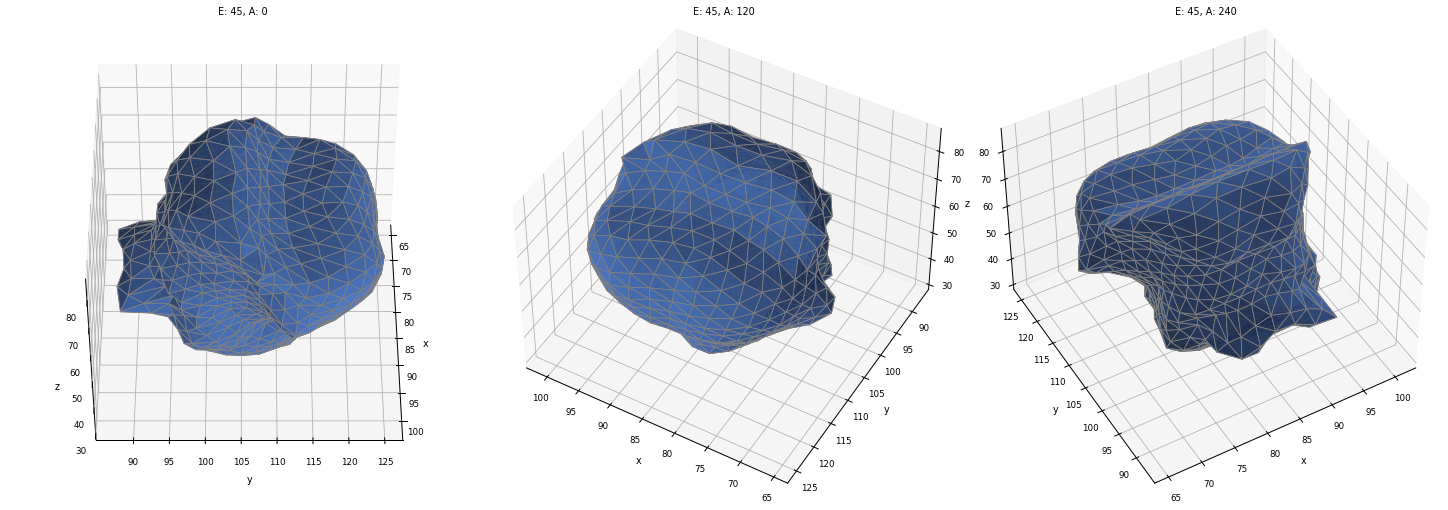

In [9]:
plot_mesh(meshes[0], faces, figsize=(20, 10), elevations=[45], azimuths=3)

## Finding feature-preserving separation boundaries

In [57]:
pca_shape_model = coma.utils.decomposition.PCAShapeModel3D()
pca_shape_model.fit(meshes)

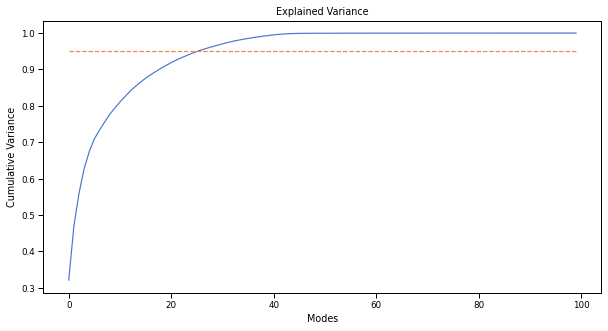

In [58]:
N = 100
plt.figure(figsize=(10, 5))
plt.title('Explained Variance')
plt.xlabel('Modes')
plt.ylabel('Cumulative Variance')
plt.plot(range(0, N), pca_shape_model.explained_variance_ratio.cumsum()[:N])
plt.plot(range(0, N), [0.95] * N, '--')
plt.show()

In [59]:
proj_dims = [10, 20, 30, 40, 50, 60]

# pca_shape_model = coma.utils.decomposition.PCAShapeModel3D()
# pca_shape_model.fit(meshes)

# pca_projs = {
#     k: pca_shape_model.project(meshes, dim=k)
#     for k in proj_dims
# }
    
# pca_projs[None] = meshes

# np.save('pca_projs_dict', pca_projs)

pca_projs = np.load('pca_projs_dict.npy', allow_pickle=True)
pca_projs = pca_projs.flatten()[0]

### LDA - brain volume classes

IGNORE THIS.

LDA - to find a projection matrix W, with eigenvectors that are the dimensions of a subspace in which the data preserves variance (i.e. the range of a variation in a visible feature) and but also allows classes to be separated. So by visualising the eigenvectors, which make up the linear projection matrix in LDA, we can see which features maintain the generalise brain shape in the standard basis, as opposed ot noise, but also enable us to discriminate between a choosen class, i.e. by viewing an LDA shape model, we see the modes along which we can discriminate between multiple classes.

Non-linear LDA - non-linear modes?

In [60]:
def lda_1d_proj_vis(lda_proj, classes, ax=None, title=''):
    """
    lda_proj: (N, 1)
    classes: (N, ) or (N, 1)
    unique_classes: (C, )
    """
    if ax is not None:
        ax.set_title(title)
    else:
        plt.title(title)
    unique_classes = np.unique(classes)
    for c in unique_classes:
        lda_proj_bin = lda_proj[classes == c]
        if ax is not None:
            sns.distplot(lda_proj_bin, rug=True, label=c, ax=ax)
        else:
            sns.distplot(lda_proj_bin, rug=True, label=c)

def lda_2d_proj_vis(lda_proj, classes, ax=None, title=''):
    """
    lda_proj: (N, 2)
    classes: (N, ) or (N, 1)
    """
    if ax is not None:
        ax.set_title(title)
    else:
        plt.title(title)
    
    data = np.concatenate([lda_proj, classes.reshape(-1, 1)], axis=1)
    data_df = pd.DataFrame(data, columns=['x1', 'x2', 'classes'])
    
    kwargs = {
        'data': data_df,
        'x': 'x1', 'y': 'x2',
        'hue': 'classes',
        'palette': 'muted',
    }
    if ax is not None:
        kwargs['ax'] = ax
        
    sns.scatterplot(**kwargs)
    
def lda_3d_proj_vis(lda_proj, classes, ax=None, title=''):
    """
    lda_proj: (N, 3)
    classes: (N, ) or (N, 1)
    ax must be 3d projection
    """
    if ax is not None:
        ax.set_title(title)
    else:
        plt.title(title)
        
    if ax is None:
        ax = plt.axes(projection='3d')
    ax.scatter3D(
        lda_proj[:, 0],
        lda_proj[:, 1],
        lda_proj[:, 2],
        c=classes,
    )

In [61]:
bins = 5
brain_vol_range = features.brain_volume.max() - features.brain_volume.min()
bin_width = np.ceil(brain_vol_range / bins)
brain_vol_class = (features.brain_volume - features.brain_volume.min()) // bin_width

In [62]:
# lda_1d_projs = {
#     k: coma.utils.decomposition.LDA().fit_project(pca_projs[k], brain_vol_class, dim=1)
#     for k in pca_projs.keys()
# }
# np.save('lda_1d_projs_dict', lda_1d_projs)

lda_1d_projs = np.load('lda_1d_projs_dict.npy', allow_pickle=True)
lda_1d_projs = lda_1d_projs.flatten()[0]

# lda_2d_projs = {
#     k: coma.utils.decomposition.LDA(True).fit_project(pca_projs[k], brain_vol_class, dim=2)
#     for k in pca_projs.keys()
# }
# np.save('lda_2d_projs_dict', lda_2d_projs)

lda_2d_projs = np.load('lda_2d_projs_dict.npy', allow_pickle=True)
lda_2d_projs = lda_2d_projs.flatten()[0]

# lda_3d_projs = {
#     k: coma.utils.decomposition.LDA(True).fit_project(pca_projs[k], brain_vol_class, dim=3)
#     for k in pca_projs.keys()
# }

# np.save('lda_3d_projs_dict', lda_3d_projs)

lda_3d_projs = np.load('lda_3d_projs_dict.npy', allow_pickle=True)
lda_3d_projs = lda_3d_projs.flatten()[0]

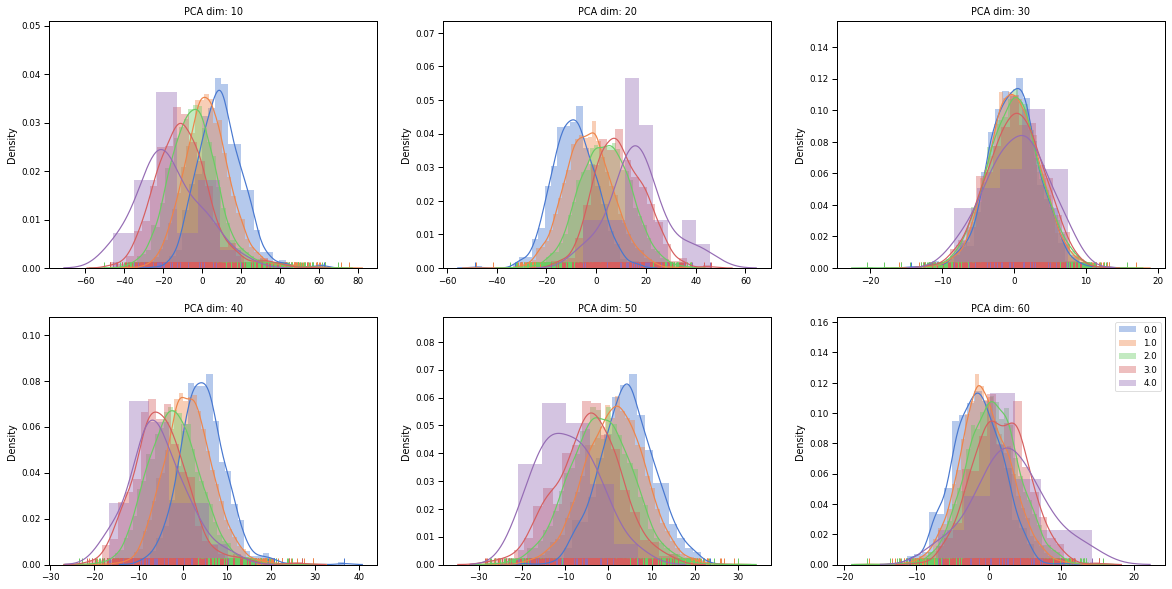

In [63]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for proj_dim, ax in zip(pca_projs.keys(), axes.flatten()):
    lda_1d_proj_vis(
        lda_1d_projs[proj_dim],
        brain_vol_class,
        ax=ax,
        title=f'PCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

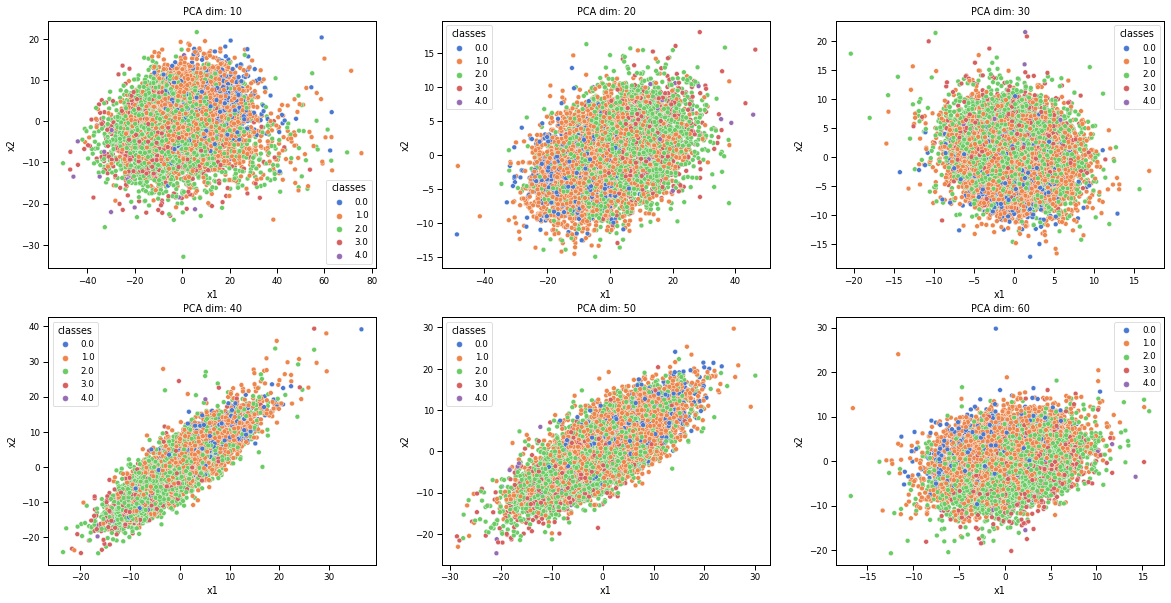

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for proj_dim, ax in zip(pca_projs.keys(), axes.flatten()):
    lda_2d_proj_vis(
        lda_2d_projs[proj_dim],
        brain_vol_class.values,
        ax=ax,
        title=f'PCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

No handles with labels found to put in legend.


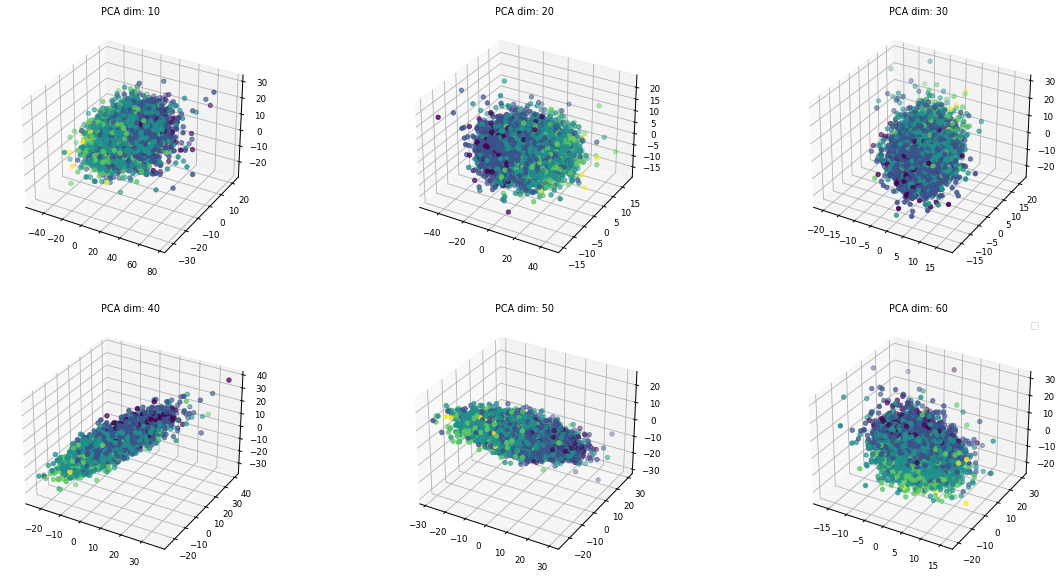

In [65]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), subplot_kw={'projection': '3d'})

for proj_dim, ax in zip(pca_projs.keys(), axes.flatten()):
    lda_3d_proj_vis(
        lda_3d_projs[proj_dim],
        brain_vol_class.values,
        ax=ax,
        title=f'PCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

### LDA - brain stem volume classes

In [66]:
bins = 5
structure_vol_range = features.structure_volume.max() - features.structure_volume.min()
bin_width = np.ceil(structure_vol_range / bins)
structure_vol_class = (features.structure_volume - features.structure_volume.min()) // bin_width

In [67]:
# lda_1d_projs = {
#     k: coma.utils.decomposition.LDA().fit_project(pca_projs[k], structure_vol_class, dim=1)
#     for k in pca_projs.keys()
# }
# np.save('lda_1d_projs_dict_struct', lda_1d_projs)

print('1D LDA proj')
lda_1d_projs = np.load('lda_1d_projs_dict_struct.npy', allow_pickle=True)
lda_1d_projs = lda_1d_projs.flatten()[0]

# lda_2d_projs = {
#     k: coma.utils.decomposition.LDA(True).fit_project(pca_projs[k], structure_vol_class, dim=2)
#     for k in pca_projs.keys()
# }
# np.save('lda_2d_projs_dict_struct', lda_2d_projs)

print('2D LDA proj')
lda_2d_projs = np.load('lda_2d_projs_dict_struct.npy', allow_pickle=True)
lda_2d_projs = lda_2d_projs.flatten()[0]

# lda_3d_projs = {
#     k: coma.utils.decomposition.LDA(True).fit_project(pca_projs[k], structure_vol_class, dim=3)
#     for k in pca_projs.keys()
# }
# np.save('lda_3d_projs_dict_struct', lda_3d_projs)

print('3D LDA proj')
lda_3d_projs = np.load('lda_3d_projs_dict_struct.npy', allow_pickle=True)
lda_3d_projs = lda_3d_projs.flatten()[0]

1D LDA proj
2D LDA proj
3D LDA proj


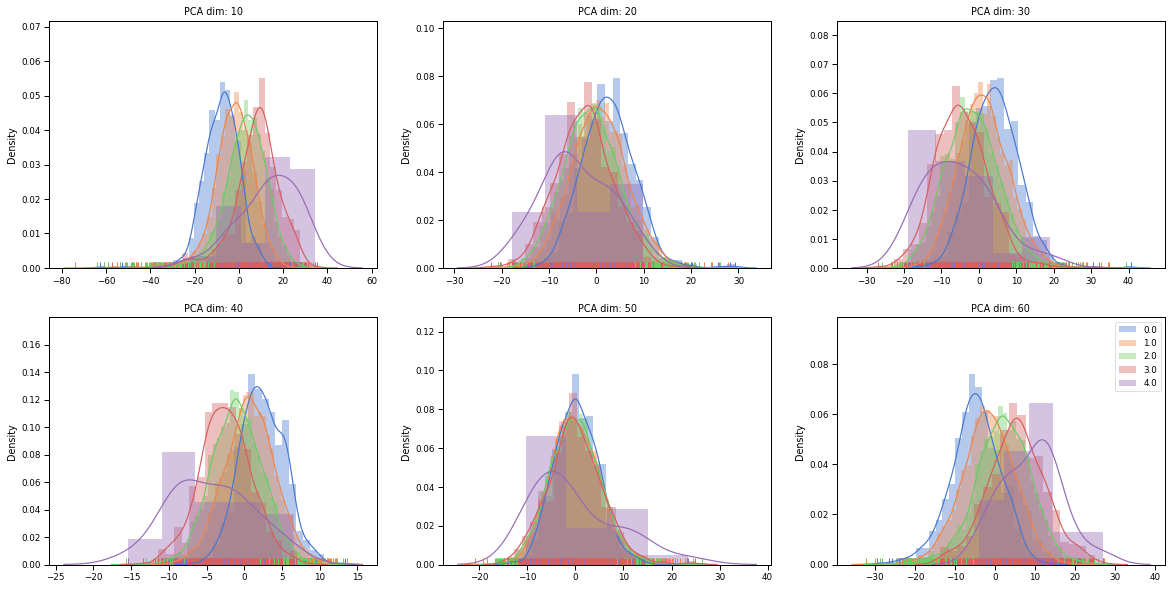

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for proj_dim, ax in zip(pca_projs.keys(), axes.flatten()):
    lda_1d_proj_vis(
        lda_1d_projs[proj_dim],
        brain_vol_class,
        ax=ax,
        title=f'PCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

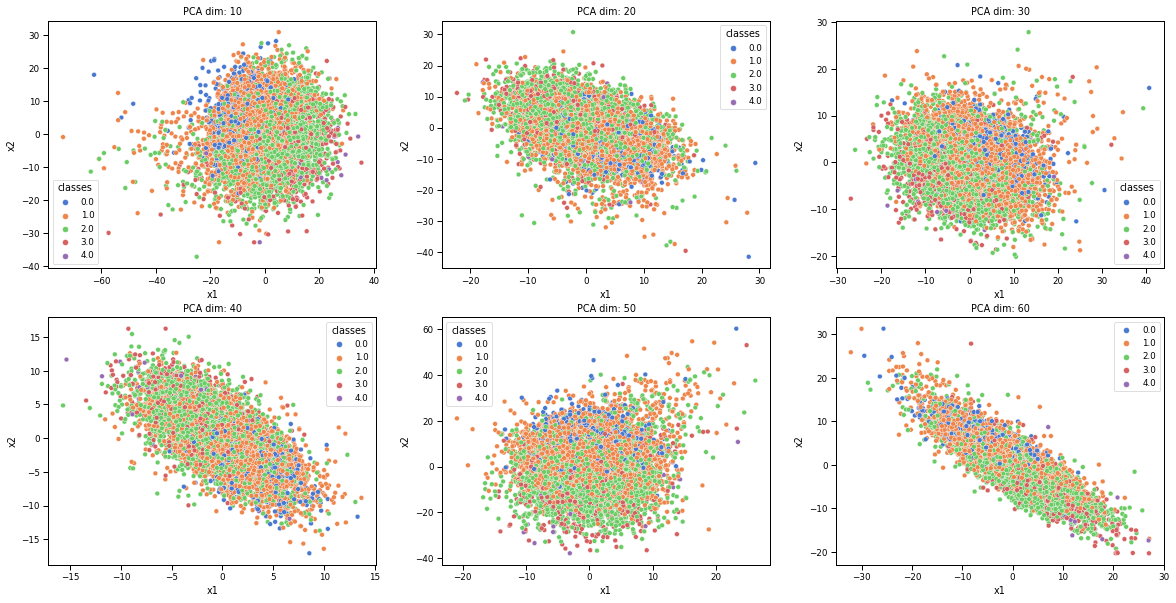

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for proj_dim, ax in zip(pca_projs.keys(), axes.flatten()):
    lda_2d_proj_vis(
        lda_2d_projs[proj_dim],
        brain_vol_class.values,
        ax=ax,
        title=f'PCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

No handles with labels found to put in legend.


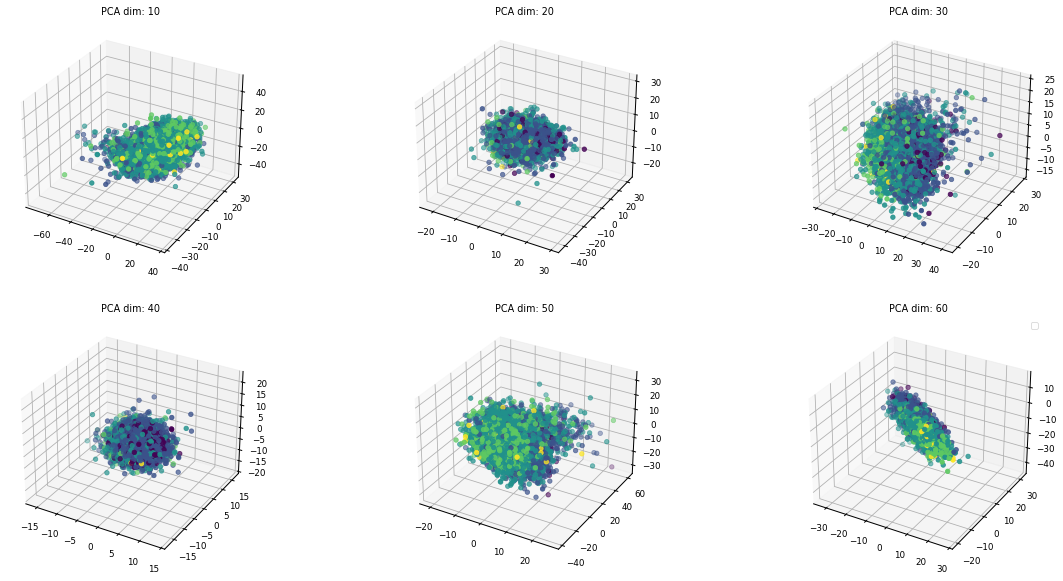

In [70]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), subplot_kw={'projection': '3d'})

for proj_dim, ax in zip(pca_projs.keys(), axes.flatten()):
    lda_3d_proj_vis(
        lda_3d_projs[proj_dim],
        brain_vol_class.values,
        ax=ax,
        title=f'PCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

### LDA - brain stem & total volume classes

In [71]:
structure_vol_class.name = 'structure_volume_class'
brain_vol_class.name = 'brain_volume_class'

In [72]:
features_list = [features, structure_vol_class, brain_vol_class]
features_with_classes = pd.concat(features_list, axis=1)

In [73]:
pair_classes = features_with_classes[['structure_volume_class', 'brain_volume_class']].values.tolist()
multi_classes = {}
# Main difference between this and DeepSCM, is that we are assuming
#  each (Data, class) pair is IID. We don't consider any dependencies.
classes = []
i = 0
for pair in pair_classes:
    pair = tuple(pair)
    if pair in multi_classes:
        classes.append(multi_classes[pair])
    else:
        classes.append(i)
        multi_classes[pair] = i
        i += 1
classes = np.array(classes)

In [ ]:
_features_list = [features_with_classes, pd.Series(classes, name='pair_classes')]
features_total = pd.concat(_features_list, axis=1)
features_total.head()

In [37]:
# classes = np.array(classes)
# lda_proj = coma.utils.decomposition.LDA(True) \
#     .fit_project(pca_projs[40], classes, dim=2)

In [38]:
# print('2D LDA proj')
# lda_2d_projs = {
#     k: coma.utils.decomposition.LDA().fit_project(pca_projs[k], classes, dim=2)
#     for k in proj_dims
# }
# np.save('lda_2d_projs_dict_pairs', lda_2d_projs)

lda_2d_projs = np.load('lda_2d_projs_dict_pairs.npy', allow_pickle=True)
lda_2d_projs = lda_2d_projs.flatten()[0]

# -------------

# print('3D LDA proj')
# lda_3d_projs = {
#     k: coma.utils.decomposition.LDA().fit_project(pca_projs[k], classes, dim=3)
#     for k in proj_dims
# }
# np.save('lda_3d_projs_dict_pairs', lda_3d_projs)

lda_3d_projs = np.load('lda_3d_projs_dict_pairs.npy', allow_pickle=True)
lda_3d_projs = lda_3d_projs.flatten()[0]

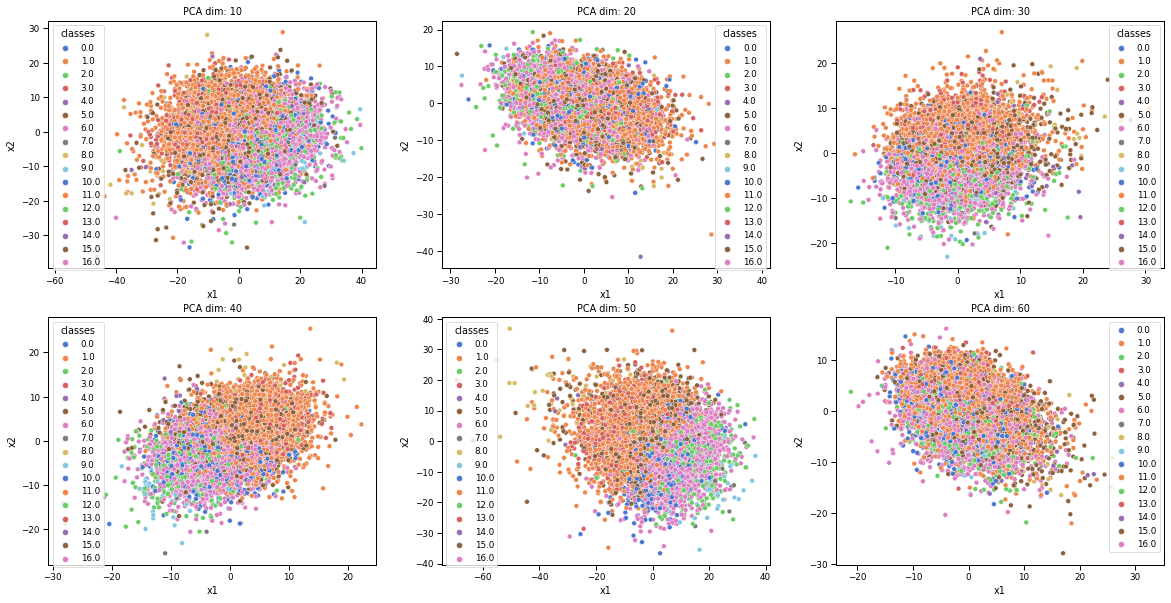

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for proj_dim, ax in zip(proj_dims, axes.flatten()):
    lda_2d_proj_vis(
        lda_2d_projs[proj_dim],
        classes,
        ax=ax,
        title=f'PCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

No handles with labels found to put in legend.


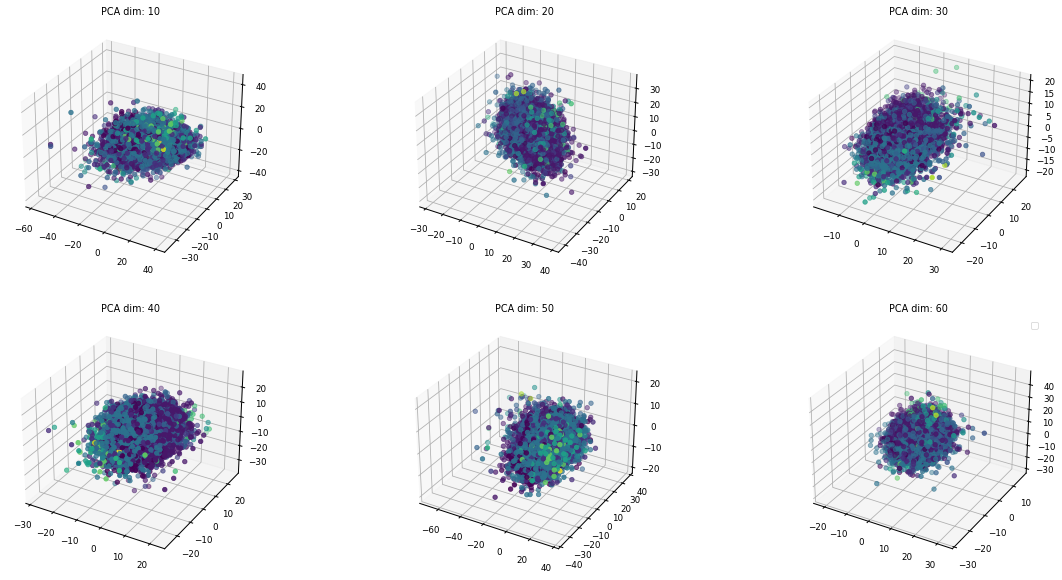

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), subplot_kw={'projection': '3d'})

for proj_dim, ax in zip(proj_dims, axes.flatten()):
    lda_3d_proj_vis(
        lda_3d_projs[proj_dim],
        classes,
        ax=ax,
        title=f'PCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

We need more modes with multiple features than we do with a single feature. There are more modes in the data. Highly multimodal dataset, hence more modes are needed to preserve a sufficient amount of variance.

How can we reduce the dimensionality of the subspace we project into?

Some thoughts - graph specific preprocess and non-linear projection.
- kernel LDA - nonlinear LDA?
- KPCA + LDA or KPCA + KLDA <-- projecting into latent manifolds via a nonlinear projections
- spectral clustering + PCA + LDA
- spectral clustering + PCA + KLDA

### KPCA + LDA

In [43]:
proj_dims = [10, 20, 30, 40, 50, 60]

# kpca_shape_model = coma.utils.decomposition.KPCAShapeModel3D(
#     kernel_type='rbf',
#     max_comps=60
# )
# kpca_shape_model.fit(meshes)

# kpca_projs = {
#     k: kpca_shape_model.project(meshes, dim=k)
#     for k in proj_dims
# }

# np.save('kpca_projs_dict', kpca_projs)

kpca_projs = np.load('kpca_projs_dict.npy', allow_pickle=True)
kpca_projs = kpca_projs.flatten()[0]

print('2D LDA proj')
# lda_2d_projs = {
#     k: coma.utils.decomposition.LDA().fit_project(kpca_projs[k], classes, dim=2)
#     for k in proj_dims
# }
# np.save('lda_2d_projs_dict_pairs_kpca', lda_2d_projs)

lda_2d_projs = np.load('lda_2d_projs_dict_pairs_kpca.npy', allow_pickle=True)
lda_2d_projs = lda_2d_projs.flatten()[0]

# -------------

print('3D LDA proj')
# lda_3d_projs = {
#     k: coma.utils.decomposition.LDA().fit_project(kpca_projs[k], classes, dim=3)
#     for k in proj_dims
# }
# np.save('lda_3d_projs_dict_pairs_kpca', lda_3d_projs)

lda_3d_projs = np.load('lda_3d_projs_dict_pairs_kpca.npy', allow_pickle=True)
lda_3d_projs = lda_3d_projs.flatten()[0]

2D LDA proj
3D LDA proj


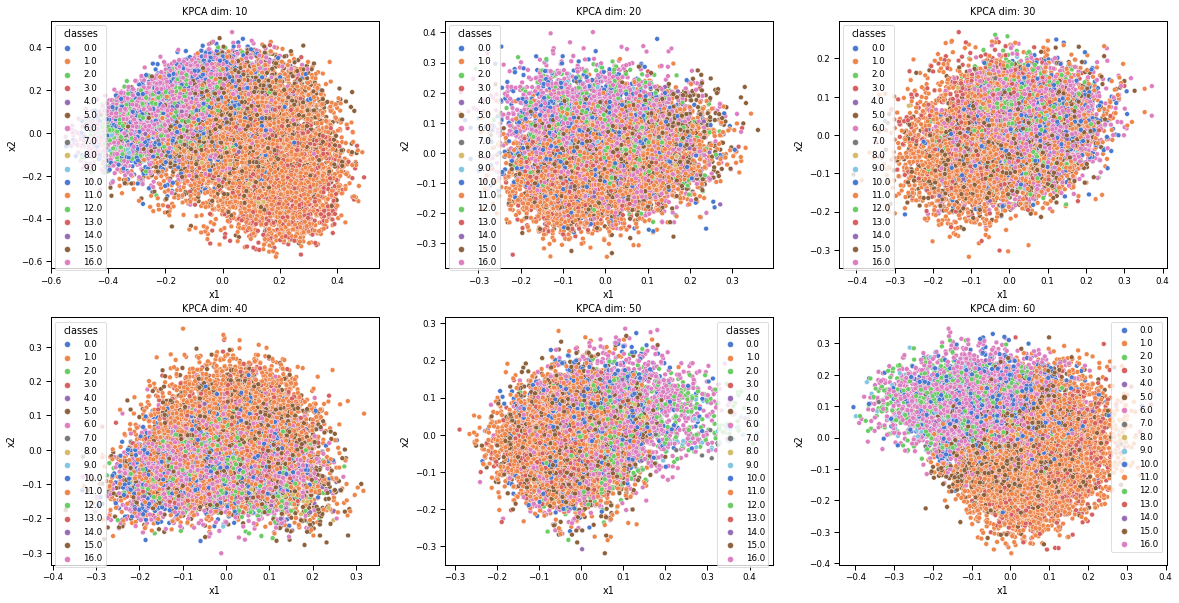

No handles with labels found to put in legend.


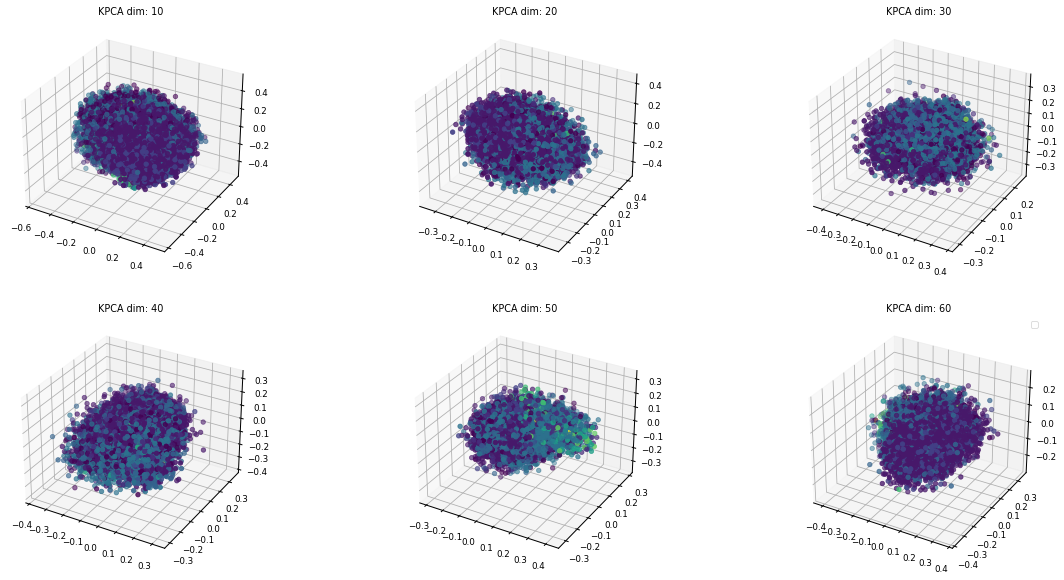

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for proj_dim, ax in zip(proj_dims, axes.flatten()):
    lda_2d_proj_vis(
        lda_2d_projs[proj_dim],
        classes,
        ax=ax,
        title=f'KPCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(20, 10), subplot_kw={'projection': '3d'})

for proj_dim, ax in zip(proj_dims, axes.flatten()):
    lda_3d_proj_vis(
        lda_3d_projs[proj_dim],
        classes,
        ax=ax,
        title=f'KPCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

### Spectral Clustering

helpful link: https://nbviewer.jupyter.org/github/drewwilimitis/Manifold-Learning/blob/master/Laplacian-Eigenmaps.ipynb

In [45]:
# Assuming no self-connections
assert len([x for x in faces if len(set(x)) != 3]) == 0

n_verts = template.points.shape[0]

# 1 hop adjacency matrix - no self-connections
adj = np.zeros((n_verts, n_verts))

for a, b, c in faces:
    adj[a, b] = True
    adj[b, a] = True
    adj[a, c] = True
    adj[c, a] = True
    adj[b, c] = True
    adj[c, b] = True

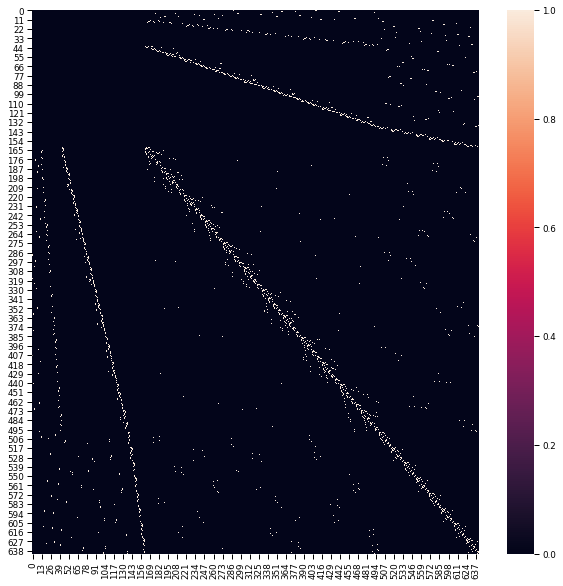

In [46]:
plt.figure(figsize=(10, 10))
sns.heatmap(adj)
plt.show()

In [175]:
import scipy
from scipy.sparse.csgraph import laplacian as graph_laplacian

from coma.utils.visualise import plot_mesh_grid

In [105]:
norm_lap, diag = graph_laplacian(
    adj,
    normed=True,
    return_diag=True,
)

# Check that the 1st eigenvalue is close to 0
eigenval, eigenvec = scipy.linalg.eigh(norm_lap)
np.testing.assert_allclose(eigenval[0], 0, atol=1e-10)

# As per source [15] in https://web.media.mit.edu/~xdong/paper/icassp20.pdf
# Alternatively, we could use ...
# scaled_norm_lap = norm_lap - np.eye(norm_lap.shape[0])
scaled_norm_lap = ((2 * norm_lap) / eigenval.max()) - np.eye(norm_lap.shape[0])
eigenval, eigenvec = scipy.linalg.eigh(scaled_norm_lap)

In [101]:
print(eigenvec[:, :0])

mesh_projs = [meshes[3, :]]
modes = 20

for mode in range(1, modes):
    _proj = eigenvec[:, :mode]
    _scale = eigenval[:mode]
    lr_approx = _proj @ np.diag(_scale) @ _proj.T
    # lr_approx = _proj @ _proj.T  # spikes
    mesh_proj = np.dot(lr_approx, meshes[0, :])
    mesh_projs.append(mesh_proj)
    
mesh_projs = np.concatenate([mesh_projs])

[]


In [102]:
eigenval.min(), eigenval.max()

(-1.0000000000000009, 1.0)

In [103]:
lr_approx.shape

(642, 642)

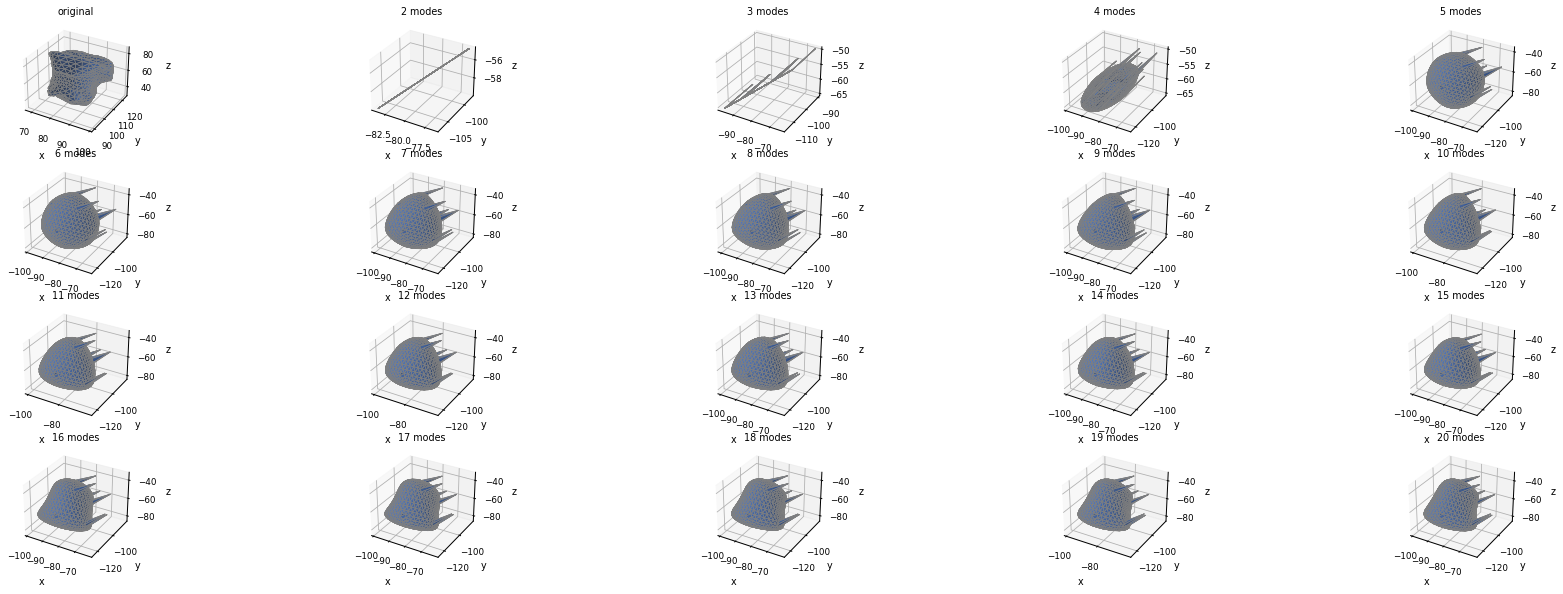

In [104]:
plot_mesh_grid(
    mesh_projs,
    faces,
    ['original'] + [f'{i + 1} modes' for i in range(1, modes)],
    figsize=(30, 10),
    nrows=modes // 5,
    ncols=5,
)

#### Spikes

In [10]:
%aimport coma.utils.mesh_sampling

/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk
(642, 3)


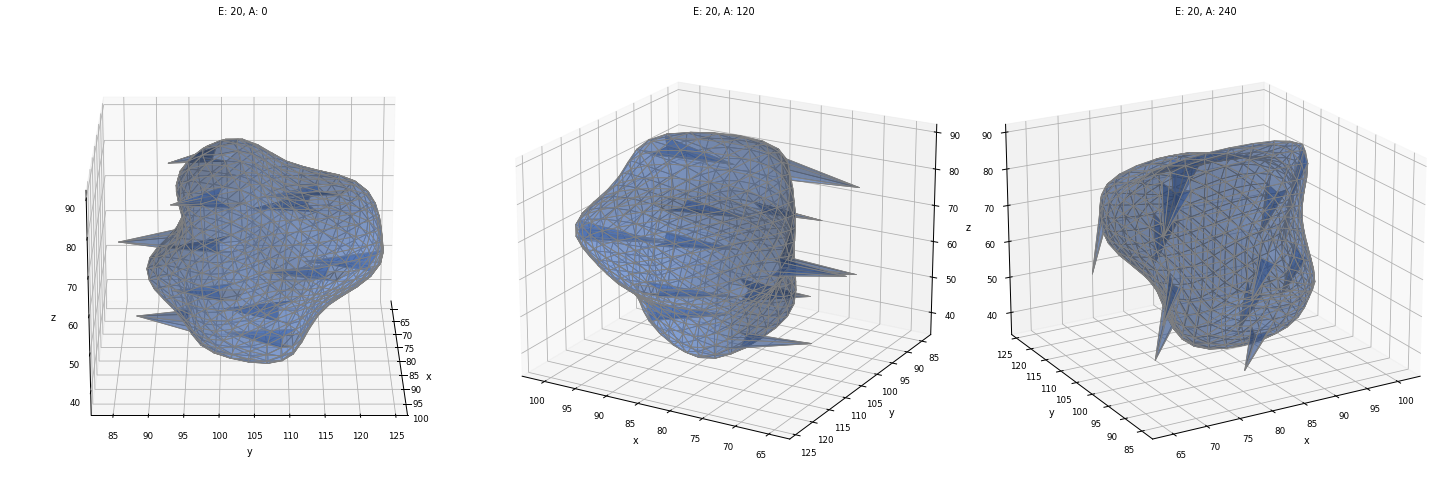

In [98]:
from scipy.sparse.csgraph import laplacian as graph_laplacian
from scipy.linalg import eigh

from coma.utils.mesh_sampling import get_adj_matrix

# substr_file = 'T1_first-L_Hipp_first.vtk'
substr_file = 'T1_first-BrStem_first.vtk'
# substr_file = 'T1_first-L_Caud_first.vtk'
# substr_file = 'T1_first-L_Pall_first.vtk'
_template_path = f'/vol/biomedic3/bglocker/brainshapes/5026976/{substr_file}'
print(_template_path)
_template = pv.read(_template_path)
_verts = _template.points
_faces = _template.faces.T.reshape(-1, 4)[:, 1:]

print(_verts.shape)

n = 80

adj = get_adj_matrix(_verts, _faces)

norm_lap, diag = graph_laplacian(
    adj,
    normed=True,
    return_diag=True,
)

# Check that the 1st eigenvalue is close to 0
_eigenval, _eigenvec = eigh(norm_lap)
np.testing.assert_allclose(_eigenval[0], 0, atol=1e-10)

scaled_norm_lap = ((2 * norm_lap) / _eigenval.max()) - np.eye(norm_lap.shape[0])
eigenval, eigenvec = eigh(scaled_norm_lap)

lap_approx = eigenvec[:, :n] @ np.diag(eigenval[:n]) @ eigenvec[:, :n].T

mesh_proj = np.zeros((_verts.shape[0], _verts.shape[1]))
mesh_proj[:, 0] = lap_approx @ _verts[:, 0]
mesh_proj[:, 1] = lap_approx @ _verts[:, 1]
mesh_proj[:, 2] = lap_approx @ _verts[:, 2]

plot_mesh(-mesh_proj, faces, figsize=(20, 10), elevations=[20], azimuths=3, alpha=0.4)

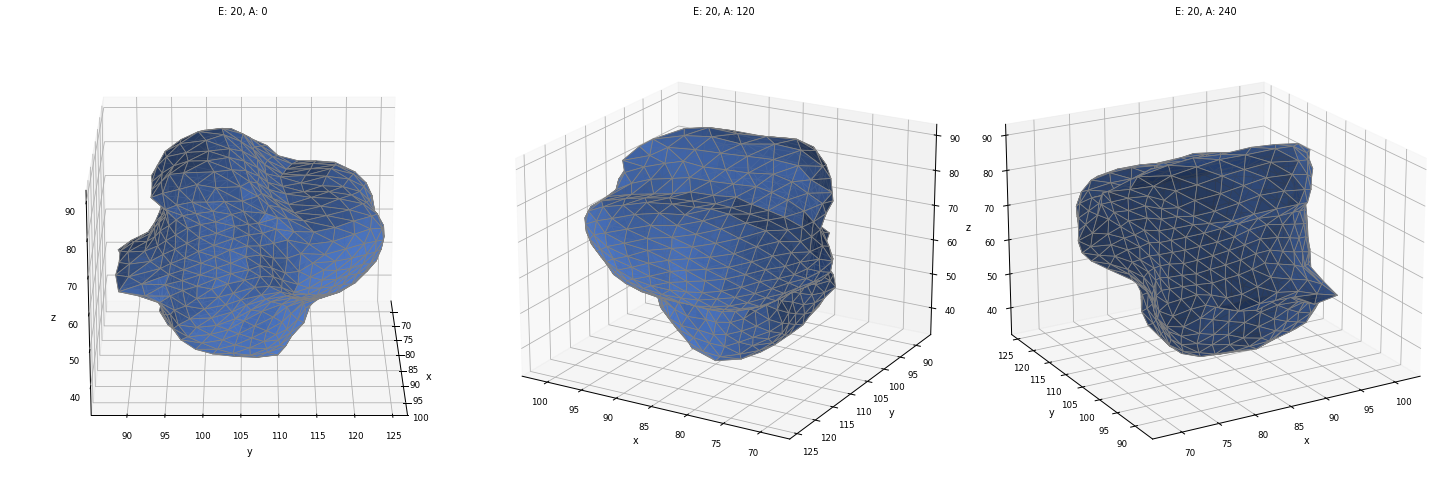

In [99]:
plot_mesh(_verts, _faces, figsize=(20, 10), elevations=[20], azimuths=3, alpha=0.8)

In [100]:
import coma.utils.visualise

/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk


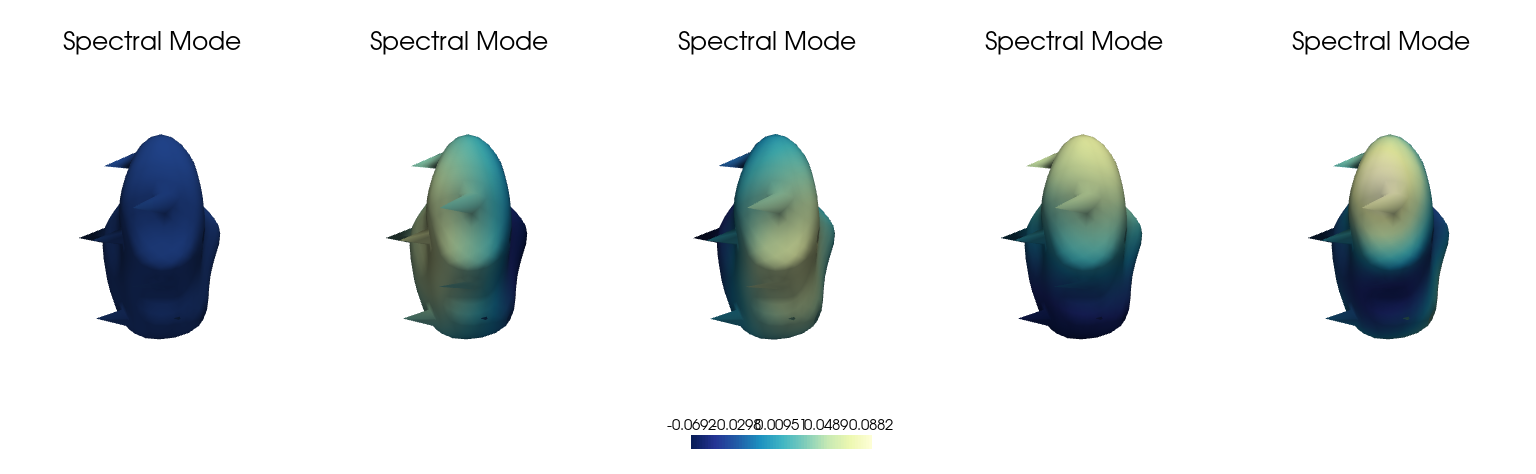

[(-4.640288377259452, 113.2421172732195, 66.46699773968957),
 (-134.03245153516292, -16.150045884683962, -62.92516541821389),
 (0.0, 0.0, 1.0)]

In [101]:
width = 768 * 2
height = int(width / (1.618 * 2))

pv.rcParams['multi_rendering_splitting_position'] = 0.5

# 2, 3, 4, 1, 2
rotations = [(0, 0, -45)] # ,(0, 0, -45), (0, 0, 190), (0, 0, 240), (0, 0, 85),]

plotter = pv.Plotter(
    shape=(1, 5),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

template_path = f'/vol/biomedic3/bglocker/brainshapes/5026976/{substr_file}'
print(template_path)
template_copy = pv.read(template_path)
template_copy.points = mesh_proj

coma.utils.visualise.plot_meshes_pyvista(
    plotter,
    [template_copy] * 5,
    rotations=rotations * 5,
    vertexcolors=eigenvec[:, :5].T,  # np.array(np.expand_dims(eigenvec[:, 0], 0)),
    vertexscalar='distance',
    smooth_shading=True,
    scalar_bar_idx=2,
    titles=['Spectral Mode'] * 5 # f'Mode {i}' for i in [3, 4, 5, 1, 2]],
)

plotter.show(screenshot='spectral_modes_brain_stem.png')

#### Reason for Spikes

In [102]:
# Degree of vertices
from collections import Counter
print('Degree of vertices')
Counter(adj.sum(axis=1))

Degree of vertices


Counter({5.0: 12, 6.0: 630})

In [103]:
print('Vertices of degree 5')
deg_5_verts = np.argwhere(adj.sum(axis=1) == 5)
deg_5_verts

Vertices of degree 5


array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11]])

In [104]:
print('Vertices with biggest difference from original position')
diffs = np.linalg.norm((-mesh_proj - meshes[0]), axis=1)
diffs.argsort()[::-1][:40]

Vertices with biggest difference from original position


array([  0,   5,  11,   6,   8,   1,   3,  10,   7,   4,   9,   2,  98,
       354, 251, 132, 355, 374, 582, 238, 359, 492, 376,  18, 184, 136,
       356, 400, 180, 109, 353, 579,  48, 476, 581, 205, 584, 296,  92,
       351])

In [105]:
eigenval.shape

(642,)

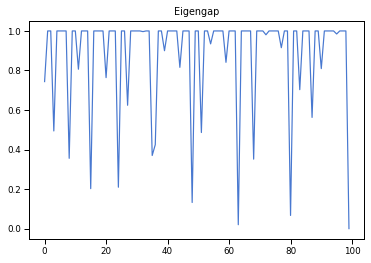

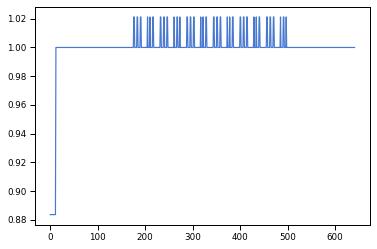

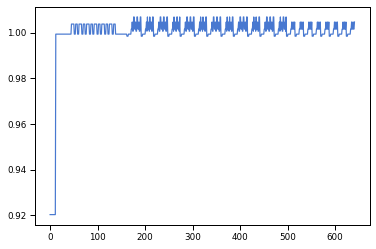

In [106]:
# plt.plot(_eigenval)
plt.title('Eigengap')
eigengap = eigenval[:-1] - eigenval[1:]
eigengap = (eigengap - eigengap.min()) / (eigengap.max() - eigengap.min())
plt.plot(eigengap[:100])
plt.show()
plt.plot(-scaled_norm_lap.sum(axis=0))
plt.show()
plt.plot(-lap_approx.sum(axis=1))
plt.show()

In [242]:
for i in range(0, 10):
    _mesh = meshes[0, [i]]
    _proj = np.sum(-lap_approx[:, [i]] * _mesh, axis=0)
    print(_proj - _mesh)

print()
    
for i in range(100, 500, 50):
    _mesh = meshes[0, [i]]
    _proj = np.sum(-lap_approx[:, [i]] * _mesh, axis=0)
    print(_proj - _mesh)

[[-10.72726086 -12.61987212  -7.03625555]]
[[ -7.38856144 -12.52002668  -6.8808376 ]]
[[ -7.89689412 -10.93738181  -5.88407668]]
[[-10.26127847 -10.97345233  -6.07371836]]
[[-10.25512967 -10.90022544  -8.71130397]]
[[ -9.98851239 -12.01351925  -4.47052873]]
[[ -8.31582221 -12.02742657  -4.12544756]]
[[ -7.97091427 -10.91663024  -8.60472204]]
[[ -9.02361698 -12.62400088  -8.16934521]]
[[ -9.08024344 -10.04380184  -6.84057366]]

[[0.21319971 0.30816606 0.15052383]]
[[0.21723517 0.32249473 0.21669854]]
[[ 5.68434189e-14 -1.42108547e-13 -2.84217094e-14]]
[[-0.10105225 -0.12928438 -0.03816536]]
[[0.39010656 0.4408122  0.24674087]]
[[0.2995109  0.41506275 0.28743676]]
[[1.42174183 2.04782299 1.28702418]]
[[-2.70006240e-13 -1.70530257e-13 -1.56319402e-13]]


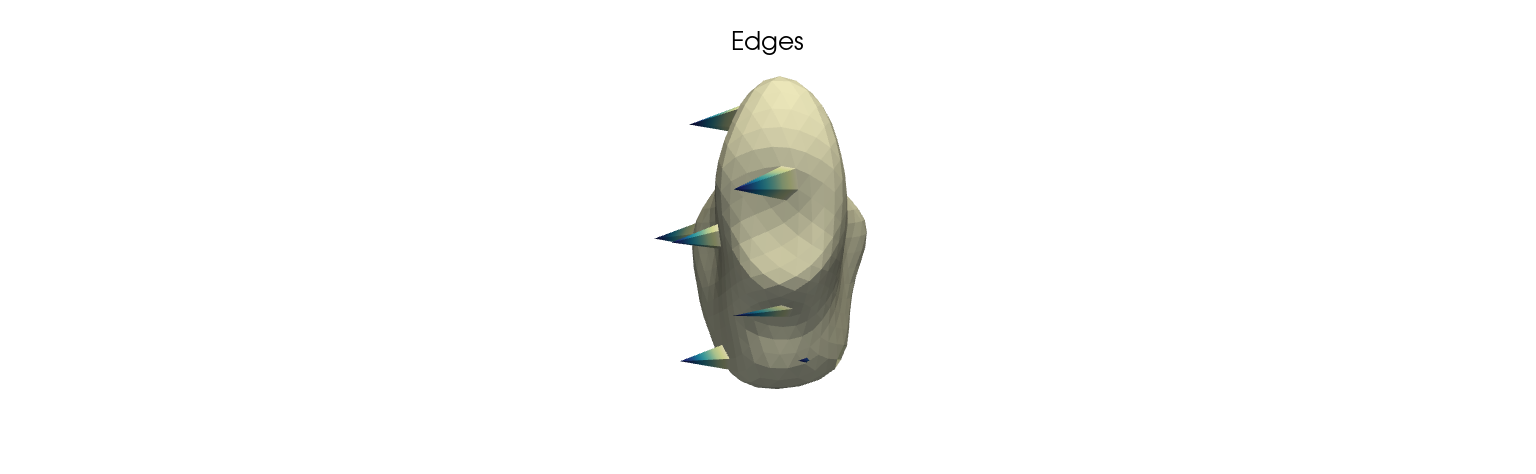

[(-48.54925414877161, 69.33315150170735, 22.558031968177417),
 (-134.03245153516292, -16.150045884683962, -62.92516541821389),
 (0.0, 0.0, 1.0)]

In [95]:
width = 768 * 2
height = int(width / (1.618 * 2))

pv.rcParams['multi_rendering_splitting_position'] = 0.5

rotations = [(0, 0, -45)]

plotter = pv.Plotter(
    shape=(1, 1),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

template_path = f'/vol/biomedic3/bglocker/brainshapes/5026976/{substr_file}'
template_copy = pv.read(template_path)
template_copy.points = mesh_proj

coma.utils.visualise.plot_meshes_pyvista(
    plotter,
    [template_copy],
    rotations=rotations,
    vertexcolors=np.expand_dims(np.sum(adj, axis=0), 0),  # Degrees matrix
    vertexscalar='distance',
    smooth_shading=False,
    scalar_bar_idx=2,
    titles=['Edges'],
#     style='wireframe',
)

plotter.show(screenshot='spectral_modes_brain_stem.png')

In [113]:
import os
import sys
import torch

import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [204]:
src_mesh = ico_sphere(3, device)

# Assuming no self-connections
assert len([x for x in faces if len(set(x)) != 3]) == 0

n_verts = src_mesh.verts_list()[0].shape[0]

# 1 hop adjacency matrix - no self-connections
adj = np.zeros((n_verts, n_verts))

for a, b, c in src_mesh.faces_list()[0]:
    adj[a, b] = True
    adj[b, a] = True
    adj[a, c] = True
    adj[c, a] = True
    adj[b, c] = True
    adj[c, b] = True
    
Counter(adj.sum(axis=0))

Counter({5.0: 12, 6.0: 630})

In [150]:
# We read the target 3D model using load_obj
# verts, faces, aux = load_obj(trg_obj)

template_path = f'/vol/biomedic3/bglocker/brainshapes/5026976/{substr_file}'
template_copy = pv.read(template_path)
print(template_copy.points.shape)

verts = torch.tensor(template_copy.points)
faces = torch.tensor(template_copy.faces.reshape(-1, 4)[:, 1:])

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

(642, 3)


In [153]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

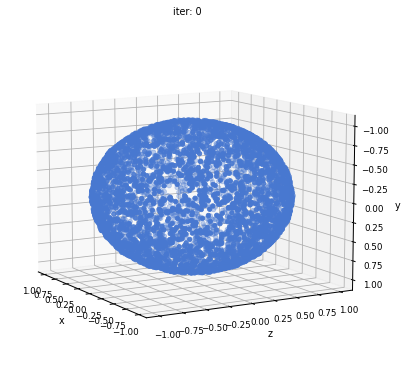

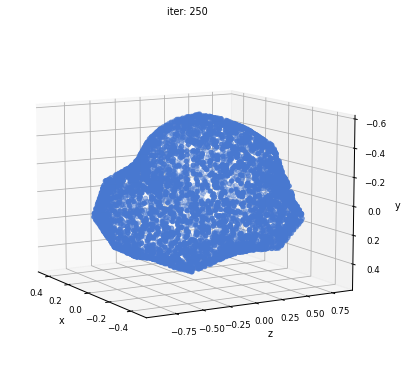

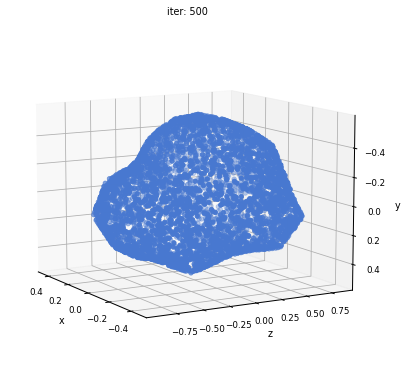

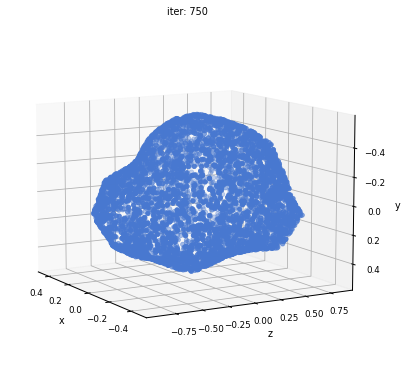

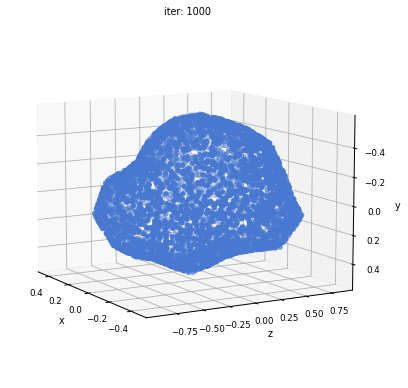

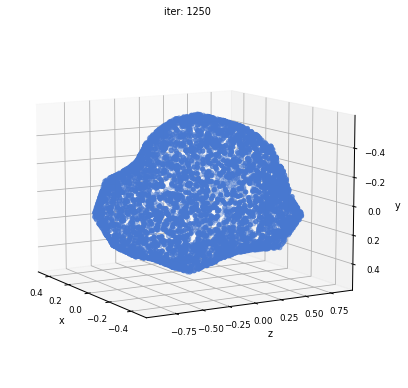

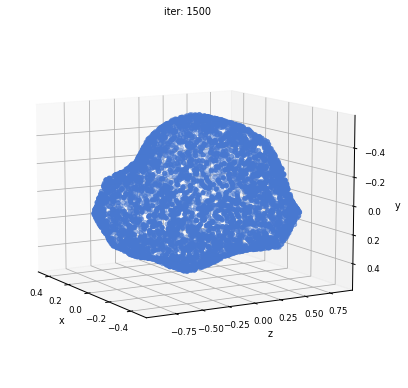

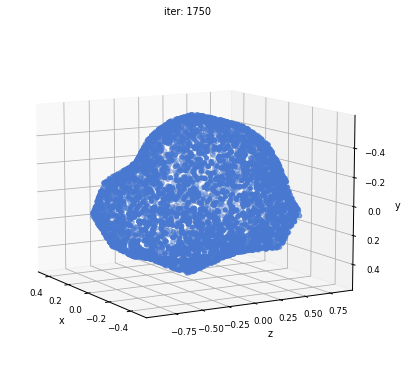

In [154]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()

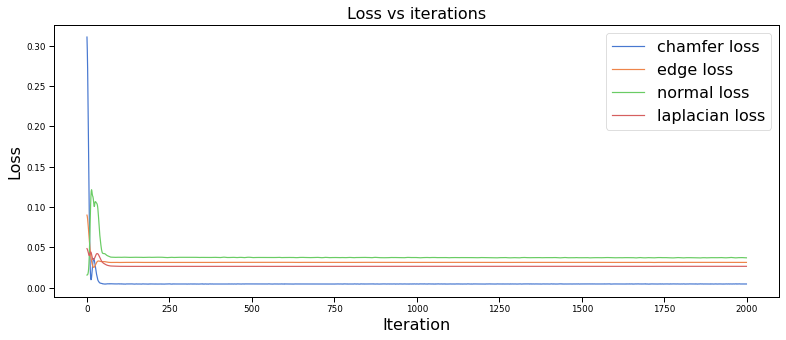

In [163]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(np.array(torch.tensor(chamfer_losses).cpu()), label="chamfer loss")
ax.plot(np.array(torch.tensor(edge_losses).cpu()), label="edge loss")
ax.plot(np.array(torch.tensor(normal_losses).cpu()), label="normal loss")
ax.plot(np.array(torch.tensor(laplacian_losses).cpu()), label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [164]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

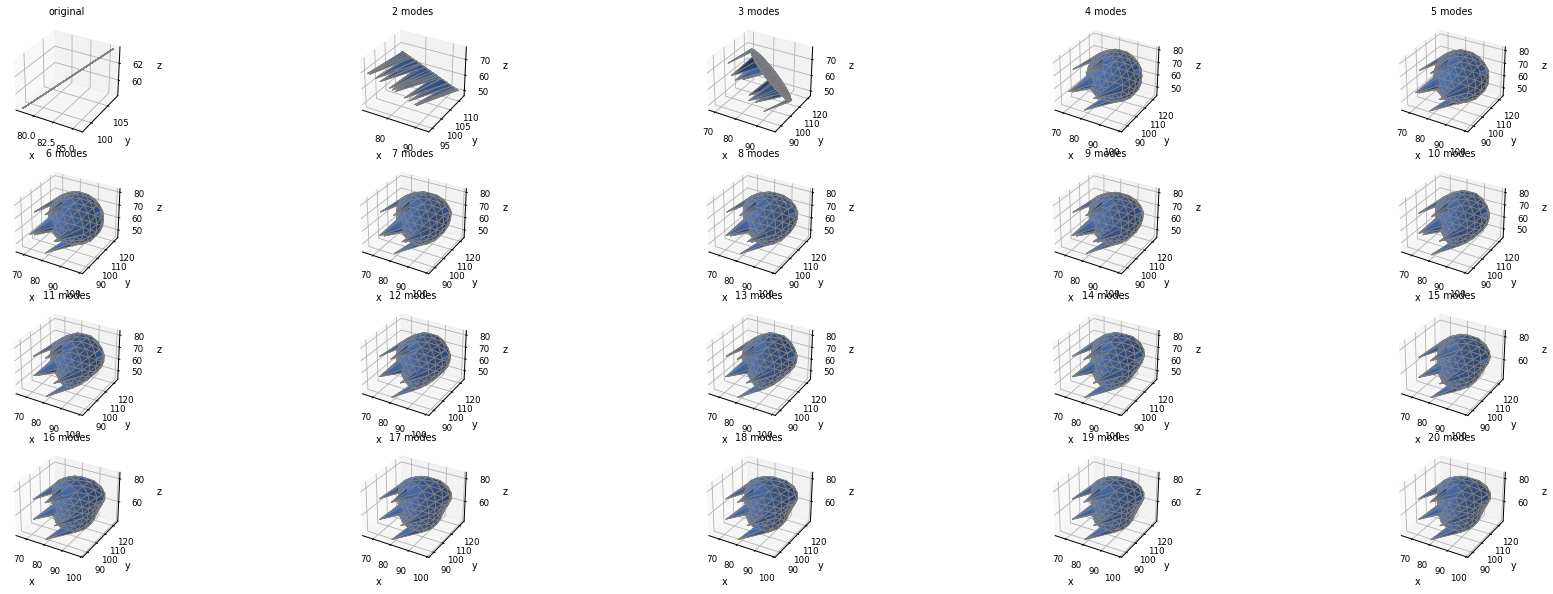

In [202]:
spectral_filter = coma.utils.decomposition.GraphSpectralFiltering(final_verts.shape[0], 'sym_scaled')
spectral_filter.fit(final_faces.cpu().numpy())

mesh_projs = []
modes = 21

for mode in range(1, modes):
    x = -spectral_filter.project(final_verts.cpu().detach().numpy(), dim=mode)
    mesh_projs.append(x)
    
mesh_projs = np.concatenate([mesh_projs], axis=0)

plot_mesh_grid(
    mesh_projs,
    final_faces.cpu().numpy(),
    ['original'] + [f'{i + 1} modes' for i in range(1, modes)],
    figsize=(30, 10),
    nrows=modes // 5,
    ncols=5,
)

### Spectral Embedding + KPCA + LDA

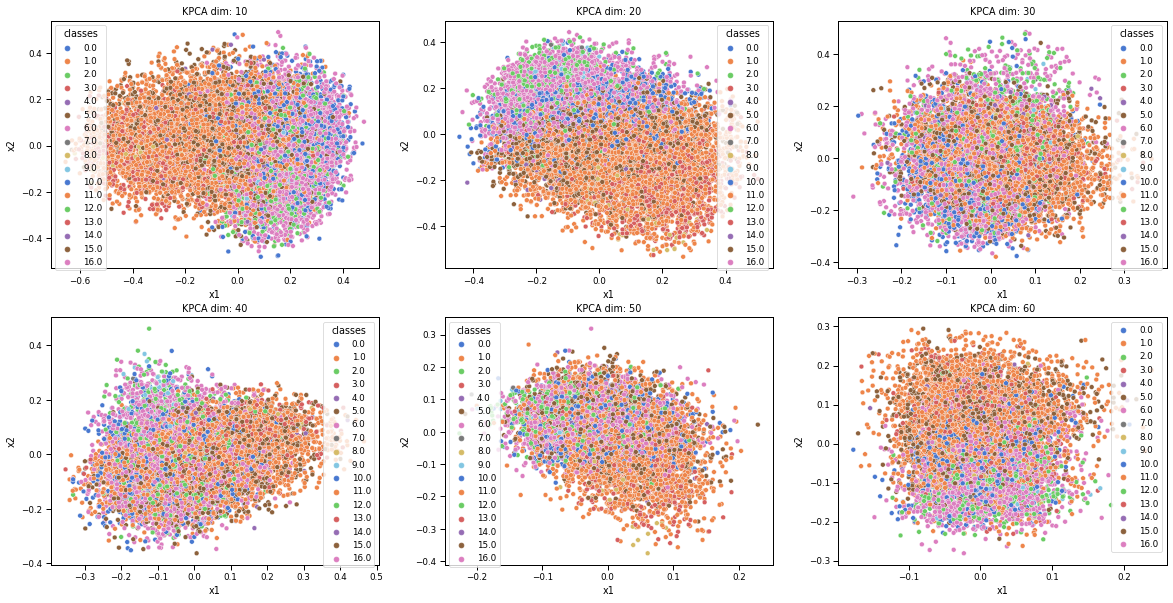

In [166]:
# modes = 25

# spectral_filter = coma.utils.decomposition.GraphSpectralFiltering(_verts.shape[0], 'sym_scaled')
# spectral_filter.fit(_faces)

# mesh_projs = np.zeros_like(meshes)
# for i in range(meshes.shape[0]):
#     if i % 1000 == 0:
#         print(i)
#     mesh_projs[i] = -spectral_filter.project(meshes[i], dim=modes)
    
proj_dims = [10, 20, 30, 40, 50, 60]

# kpca_shape_model = coma.utils.decomposition.KPCAShapeModel3D(
#     kernel_type='rbf',
#     max_comps=60
# )
# kpca_shape_model.fit(mesh_projs)

# kpca_projs = {}
# for k in proj_dims:
#     print(k)
#     kpca_projs[k] = kpca_shape_model.project(mesh_projs, dim=k)

# np.save('kpca_spec_projs_dict', kpca_projs)
# kpca_projs = np.load('kpca_spec_projs_dict.npy', allow_pickle=True)
# kpca_projs = kpca_projs.flatten()[0]

# lda_2d_projs = {
#     k: coma.utils.decomposition.LDA().fit_project(kpca_projs[k], classes, dim=2)
#     for k in proj_dims
# }
# np.save('lda_2d_projs_dict_pairs_kpca_spec', lda_2d_projs)
lda_2d_projs = np.load('lda_2d_projs_dict_pairs_kpca_spec.npy', allow_pickle=True)
lda_2d_projs = lda_2d_projs.flatten()[0]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for proj_dim, ax in zip(proj_dims, axes.flatten()):
    lda_2d_proj_vis(
        lda_2d_projs[proj_dim],
        classes,
        ax=ax,
        title=f'KPCA dim: {proj_dim}',
    )
    
plt.legend()
plt.show()

### Interactive Plots

In [ ]:
# !pip install ipyvolume

In [ ]:
# %%bash
# jupyter nbextension enable --sys-prefix --py pythreejs

In [ ]:
# from ipywidgets import interact, fixed
# import ipyvolume as ipv

In [ ]:
# s = 1/2**0.5
# # 4 vertices for the tetrahedron
# x = np.array([1.,  -1, 0,  0])
# y = np.array([0,   0, 1., -1])
# z = np.array([-s, -s, s,  s])
# # and 4 surfaces (triangles), where the number refer to the vertex index
# triangles = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1,3,2)]

# ipv.figure()
# # we draw the tetrahedron
# mesh = ipv.plot_trisurf(x, y, z, triangles=triangles, color='orange')
# # and also mark the vertices
# ipv.scatter(x, y, z, marker='sphere', color='blue')
# ipv.xyzlim(-2, 2)
# ipv.show()

At mode 10 and onwards, we begin to see spikes on the surface mesh. This suggests that the true brain surface does consist of latent spikes, which when averaged out, create the smooth surface we expect. It is posssible, that large weights in the K learned matrices in the ChebConv early on in training could assign more importance to spiky eigenmeshes, resulting in the spikes early on in training.



- Shape modes of different ages and sexes, LDA? or just PCA shape models on different filters?
- interactive plot
- identify names for parts of the brain stem and hippocampus and write short description about how they are changing
- Calculate explained variance <-- determine how many modes make up explained variance of approx 90% and identify which parts of the brain they belong to.
- LDA - project each datapoints into 2D space after LDA. Then decide how they are being clustered.
- Do shape modelling with LDA to determine what the defining modes are in each age group and gender.